# Inspect the phase angles and reduced magnitudes for DP1 objects
Author: James E. Robinson

Query all objects and observations in DP1 and generate summary statistics for the phase angles and reduced magnitudes: range, min, max, mean.
This should give an indication of objects that may have lightcurve amplitude variations or interesting colours.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import astropy.units as u

from lsst.rsp import get_tap_service

In [2]:
service = get_tap_service("tap")
assert service is not None

# Query for all properties from the SSObject and and MPCORB tables

In [3]:
query = """SELECT * 
            FROM
                dp1.MPCORB as mpc
                INNER JOIN dp1.SSObject as sso
                ON mpc.ssObjectId = sso.ssObjectId
                """

In [4]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is COMPLETED


In [5]:
assert job.phase == 'COMPLETED'
result = job.fetch_result()
print(len(result))

431


In [6]:
df_obj = pd.DataFrame(result)

In [7]:
# calculate the semimajor axis
df_obj["a"] = df_obj["q"] / (1.0 - df_obj["e"])

In [8]:
df_obj

,discoverySubmissionDate,e,epoch,incl,mpcDesignation,mpcH,node,numObs,peri,q,ssObjectId,t_p,a
0,NaN,0.085083,60800.0,6.172520,1981 EJ47,16.309000,167.717781,3,65.922178,2.214434,20890932542191434,59972.863024,2.420366
1,NaN,0.123997,60800.0,4.667199,1984 SO5,13.515000,141.582140,8,249.862190,2.352472,20890945661711695,60577.600657,2.685462
2,NaN,0.156926,60800.0,5.621222,1985 VD,12.636000,126.649152,6,219.174026,2.652810,20890950007009348,60374.602034,3.146592
3,NaN,0.101921,60800.0,4.840250,1985 VE,13.773000,164.372768,19,341.671284,2.089647,20890950007009349,59651.282367,2.326797
4,NaN,0.115775,60800.0,5.202303,1991 SJ,14.892000,139.414544,11,83.443140,1.942957,20892032288436298,60023.287287,2.197356
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,60853.579024,0.054627,60800.0,6.179854,2024 WT106,19.931000,181.090835,16,192.165559,2.537547,23133931615303737,60501.079343,2.684175
427,60853.579024,0.170152,60800.0,5.474783,2024 WU106,20.583000,98.001770,13,309.617568,2.178832,23133931615303984,60634.329130,2.625581
428,60853.579024,0.066187,60800.0,9.470827,2024 WV106,18.792999,192.908708,8,85.085184,2.892919,23133931615303985,59967.639914,3.097965
429,60853.579024,0.122949,60800.0,5.219185,2024 WW106,19.146000,121.301046,10,239.320465,2.821248,23133931615303986,60425.467475,3.216744


# Query for all observations in the DiaSource and SSSource tables

In [9]:
query = """
SELECT *
FROM
    dp1.DiaSource as dia
INNER JOIN
    dp1.SSSource as sss
ON
    dia.diaSourceId = sss.diaSourceId
"""

In [10]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is COMPLETED


In [11]:
assert job.phase == 'COMPLETED'
result = job.fetch_result()
print(len(result))

5988


In [12]:
df_obs = pd.DataFrame(result)

In [13]:
df_obs

,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,band,bboxSize,centroid_flag,coord_dec,coord_ra,dec,...,trailDec,trailFlux,trailLength,trailRa,trail_flag_edge,visit,x,xErr,y,yErr
0,-874.994019,1495.380005,False,False,z,22,False,6.341699,37.247419,6.341689,...,6.341758,-5911.839844,1.166274,37.247558,False,2024120700164,3748.079052,NaN,2931.863641,NaN
1,147.177994,1548.069946,False,False,z,25,False,6.341699,37.247419,6.341710,...,6.341757,5432.430176,1.289220,37.247568,False,2024120700160,1264.212374,NaN,2707.167473,NaN
2,4369.830078,353.485992,False,False,g,30,False,6.293278,37.819684,6.293278,...,6.293275,4433.740234,1.415693,37.819695,False,2024112700091,22.427637,0.209728,1919.808569,0.221328
3,4400.299805,343.942993,False,False,g,30,False,6.293452,37.820504,6.293452,...,6.293451,4178.109863,1.363738,37.820504,False,2024112700083,1134.479535,0.144288,3253.946654,0.205547
4,4484.660156,348.970001,False,False,g,27,False,6.293351,37.820085,6.293351,...,6.293353,4100.950195,0.849869,37.820084,False,2024112700087,690.930377,0.128695,3934.376414,0.170207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5983,18567.300781,382.354004,False,False,g,29,False,7.852124,37.620779,7.852128,...,7.852128,17825.199219,0.773633,37.620783,False,2024112600114,814.944672,0.040874,2335.915101,0.042200
5984,22581.800781,386.095001,True,False,g,59,True,7.852093,37.619696,7.852093,...,NaN,NaN,NaN,NaN,False,2024112600116,386.736761,0.036542,3019.762131,0.033804
5985,24185.199219,402.345001,False,False,g,32,False,7.852046,37.618389,7.852046,...,7.852046,23425.599609,0.777747,37.618388,False,2024112600122,2211.760655,0.034983,1236.339713,0.031280
5986,46801.800781,838.929993,False,False,i,29,False,7.851899,37.617316,7.852008,...,7.852008,49010.300781,0.823361,37.617325,False,2024112600124,881.878564,0.031804,2369.370170,0.023668


# Calculate the magnitudes from flux
See "Using astropy for unit conversion" https://community.lsst.org/t/photocalib-has-replaced-calib-welcoming-our-nanojansky-overlords/3648

In [14]:
# Flux in nanoJanskys to AB magnitudes - NB negative fluxes will give nans
df_obs["apABmag"] = (np.array(df_obs["apFlux"]) * u.nJy).to(u.ABmag).value
df_obs["psfABmag"] = (np.array(df_obs["psfFlux"]) * u.nJy).to(u.ABmag).value
df_obs["trailABmag"] = (np.array(df_obs["trailFlux"]) * u.nJy).to(u.ABmag).value

# Calculate the reduced magnitude using the distances of each observation
thdist = df_obs['topocentricDist']*df_obs['heliocentricDist']
df_obs["red_apABmag"] = df_obs['apABmag'] - 5.0*np.log10(thdist)
df_obs["red_psfABmag"] = df_obs['psfABmag'] - 5.0*np.log10(thdist)
df_obs["red_trailABmag"] = df_obs['trailABmag'] - 5.0*np.log10(thdist)

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [15]:
df_obs

,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,band,bboxSize,centroid_flag,coord_dec,coord_ra,dec,...,x,xErr,y,yErr,apABmag,psfABmag,trailABmag,red_apABmag,red_psfABmag,red_trailABmag
0,-874.994019,1495.380005,False,False,z,22,False,6.341699,37.247419,6.341689,...,3748.079052,NaN,2931.863641,NaN,NaN,24.232555,NaN,NaN,20.272406,NaN
1,147.177994,1548.069946,False,False,z,25,False,6.341699,37.247419,6.341710,...,1264.212374,NaN,2707.167473,NaN,25.980396,25.686064,22.062513,22.020264,21.725931,18.102381
2,4369.830078,353.485992,False,False,g,30,False,6.293278,37.819684,6.293278,...,22.427637,0.209728,1919.808569,0.221328,22.298840,22.315632,22.283075,18.822573,18.839365,18.806808
3,4400.299805,343.942993,False,False,g,30,False,6.293452,37.820504,6.293452,...,1134.479535,0.144288,3253.946654,0.205547,22.291296,22.377724,22.347549,18.815075,18.901505,18.871330
4,4484.660156,348.970001,False,False,g,27,False,6.293351,37.820085,6.293351,...,690.930377,0.128695,3934.376414,0.170207,22.270678,22.363127,22.367790,18.794434,18.886883,18.891546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5983,18567.300781,382.354004,False,False,g,29,False,7.852124,37.620779,7.852128,...,814.944672,0.040874,2335.915101,0.042200,20.728130,20.733982,20.772417,18.035534,18.041386,18.079823
5984,22581.800781,386.095001,True,False,g,59,True,7.852093,37.619696,7.852093,...,386.736761,0.036542,3019.762131,0.033804,20.515604,20.489614,NaN,17.822927,17.796938,NaN
5985,24185.199219,402.345001,False,False,g,32,False,7.852046,37.618389,7.852046,...,2211.760655,0.034983,1236.339713,0.031280,20.441128,20.436213,20.475773,17.748354,17.743439,17.782999
5986,46801.800781,838.929993,False,False,i,29,False,7.851899,37.617316,7.852008,...,881.878564,0.031804,2369.370170,0.023668,19.724346,19.648733,19.674284,17.031494,16.955881,16.981432


# Group all detections by ssObjectId
This will allow us to see how the overall phase angle coverage and reduced magnitude changes per object (across all bands)

In [16]:
# gb_obs = df_obs.groupby("ssObjectId")
gb_obs = df_obs.dropna(subset = ["red_apABmag","red_psfABmag"]).groupby("ssObjectId") # we need to drop nan mags otherwise the summary stat for np.ptp will also be nan

In [17]:
# range
df_ptp = gb_obs[['red_apABmag',"red_psfABmag","phaseAngle"]].agg(np.ptp).reset_index()
df_ptp = df_ptp.rename({'red_apABmag':"range_red_apABmag",
                        'red_psfABmag':"range_red_psfABmag",
                        "phaseAngle":"range_phaseAngle"}, axis = 1)
df_ptp

,ssObjectId,range_red_apABmag,range_red_psfABmag,range_phaseAngle
0,20890932542191434,5.279093,3.815758,0.003512
1,20890945661711695,2.317986,1.770698,0.004910
2,20890950007009348,1.055009,1.283315,0.003488
3,20890950007009349,1.297783,1.391209,2.225051
4,20892032288436298,0.862363,0.888658,0.413195
...,...,...,...,...
425,23133931615303737,3.185421,1.277914,1.960573
426,23133931615303984,1.483965,1.202869,0.912843
427,23133931615303985,1.547022,1.027958,1.198008
428,23133931615303986,2.491463,0.567289,0.670123


In [18]:
# min
df_min = gb_obs[["red_apABmag","red_psfABmag","phaseAngle"]].min().reset_index()
df_min = df_min.rename({'red_apABmag':"min_red_apABmag",
                        'red_psfABmag':"min_red_psfABmag",
                        "phaseAngle":"min_phaseAngle"}, axis = 1)
df_min

,ssObjectId,min_red_apABmag,min_red_psfABmag,min_phaseAngle
0,20890932542191434,16.914629,16.891289,13.534070
1,20890945661711695,14.313343,14.260625,15.061424
2,20890950007009348,13.021914,12.847406,12.398612
3,20890950007009349,13.833876,13.837357,10.041774
4,20892032288436298,15.050570,15.022604,11.020818
...,...,...,...,...
425,23133931615303737,19.796806,19.948296,9.313183
426,23133931615303984,20.524193,20.689293,12.095402
427,23133931615303985,18.781513,18.842999,7.458406
428,23133931615303986,19.617092,19.563734,8.922410


In [19]:
# max
df_max = gb_obs[["red_apABmag","red_psfABmag","phaseAngle"]].max().reset_index()
df_max = df_max.rename({'red_apABmag':"max_red_apABmag",
                        'red_psfABmag':"max_red_psfABmag",
                        "phaseAngle":"max_phaseAngle"}, axis = 1)
df_max

,ssObjectId,max_red_apABmag,max_red_psfABmag,max_phaseAngle
0,20890932542191434,22.193722,20.707047,13.537582
1,20890945661711695,16.631329,16.031322,15.066334
2,20890950007009348,14.076922,14.130721,12.402100
3,20890950007009349,15.131659,15.228565,12.266825
4,20892032288436298,15.912932,15.911262,11.434012
...,...,...,...,...
425,23133931615303737,22.982227,21.226210,11.273756
426,23133931615303984,22.008158,21.892162,13.008245
427,23133931615303985,20.328535,19.870956,8.656414
428,23133931615303986,22.108555,20.131023,9.592533


In [20]:
# mean
df_mean = gb_obs[["red_apABmag","red_psfABmag","phaseAngle"]].mean().reset_index()
df_mean = df_mean.rename({'red_apABmag':"mean_red_apABmag",
                          'red_psfABmag':"mean_red_psfABmag",
                        "phaseAngle":"mean_phaseAngle"}, axis = 1)

In [21]:
# Overall summary dataframe
df_mag = df_ptp.copy()
df_mag = df_mag.merge(df_min, on = "ssObjectId")
df_mag = df_mag.merge(df_max, on = "ssObjectId")
df_mag = df_mag.merge(df_mean, on = "ssObjectId")
df_mag = df_mag.merge(df_obj, on = "ssObjectId")

df_mag

,ssObjectId,range_red_apABmag,range_red_psfABmag,range_phaseAngle,min_red_apABmag,min_red_psfABmag,min_phaseAngle,max_red_apABmag,max_red_psfABmag,max_phaseAngle,...,epoch,incl,mpcDesignation,mpcH,node,numObs,peri,q,t_p,a
0,20890932542191434,5.279093,3.815758,0.003512,16.914629,16.891289,13.534070,22.193722,20.707047,13.537582,...,60800.0,6.172520,1981 EJ47,16.309000,167.717781,3,65.922178,2.214434,59972.863024,2.420366
1,20890945661711695,2.317986,1.770698,0.004910,14.313343,14.260625,15.061424,16.631329,16.031322,15.066334,...,60800.0,4.667199,1984 SO5,13.515000,141.582140,8,249.862190,2.352472,60577.600657,2.685462
2,20890950007009348,1.055009,1.283315,0.003488,13.021914,12.847406,12.398612,14.076922,14.130721,12.402100,...,60800.0,5.621222,1985 VD,12.636000,126.649152,6,219.174026,2.652810,60374.602034,3.146592
3,20890950007009349,1.297783,1.391209,2.225051,13.833876,13.837357,10.041774,15.131659,15.228565,12.266825,...,60800.0,4.840250,1985 VE,13.773000,164.372768,19,341.671284,2.089647,59651.282367,2.326797
4,20892032288436298,0.862363,0.888658,0.413195,15.050570,15.022604,11.020818,15.912932,15.911262,11.434012,...,60800.0,5.202303,1991 SJ,14.892000,139.414544,11,83.443140,1.942957,60023.287287,2.197356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,23133931615303737,3.185421,1.277914,1.960573,19.796806,19.948296,9.313183,22.982227,21.226210,11.273756,...,60800.0,6.179854,2024 WT106,19.931000,181.090835,16,192.165559,2.537547,60501.079343,2.684175
426,23133931615303984,1.483965,1.202869,0.912843,20.524193,20.689293,12.095402,22.008158,21.892162,13.008245,...,60800.0,5.474783,2024 WU106,20.583000,98.001770,13,309.617568,2.178832,60634.329130,2.625581
427,23133931615303985,1.547022,1.027958,1.198008,18.781513,18.842999,7.458406,20.328535,19.870956,8.656414,...,60800.0,9.470827,2024 WV106,18.792999,192.908708,8,85.085184,2.892919,59967.639914,3.097965
428,23133931615303986,2.491463,0.567289,0.670123,19.617092,19.563734,8.922410,22.108555,20.131023,9.592533,...,60800.0,5.219185,2024 WW106,19.146000,121.301046,10,239.320465,2.821248,60425.467475,3.216744


In [22]:
df_mag.sort_values("range_red_apABmag")

,ssObjectId,range_red_apABmag,range_red_psfABmag,range_phaseAngle,min_red_apABmag,min_red_psfABmag,min_phaseAngle,max_red_apABmag,max_red_psfABmag,max_phaseAngle,...,epoch,incl,mpcDesignation,mpcH,node,numObs,peri,q,t_p,a
83,21163624260711769,0.000000,0.000000,0.000000,17.613522,17.599176,24.292860,17.613522,17.599176,24.292860,...,60800.0,33.052266,2004 BY85,16.261999,134.265948,1,313.831951,1.924589,60673.150506,2.609219
135,21163641456899922,0.000000,0.000000,0.000000,23.461323,19.698051,9.687546,23.461323,19.698051,9.687546,...,60800.0,5.165896,2008 CR17,16.947001,165.642051,1,286.510832,2.489621,59174.062266,2.722811
318,21165810483998787,0.000000,0.000000,0.000000,17.017170,17.669975,11.131622,17.017170,17.669975,11.131622,...,59800.0,26.204283,2021 GC170,17.513000,191.168625,1,65.228101,2.629358,59377.463796,3.254288
304,21164741153143117,0.000000,0.000000,0.000000,20.078955,20.054787,23.914167,20.078955,20.054787,23.914167,...,60600.0,24.699138,2018 NM29,19.056000,130.587398,1,337.224701,1.817673,59775.404173,1.955688
139,21163641490782552,0.000000,0.000000,0.000000,29.208622,20.906475,14.651114,29.208622,20.906475,14.651114,...,60800.0,4.956743,2008 EX69,17.221001,118.174482,2,341.672228,2.304101,59161.380938,2.732951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,21163611660695877,5.798615,10.538469,0.006134,17.560144,17.452656,16.412558,23.358759,27.991125,16.418692,...,60800.0,4.264410,2001 SE39,16.464001,150.612487,8,268.680651,2.152358,60665.142320,2.754356
108,21163632917362253,5.849710,5.557251,3.427237,16.170553,16.168680,8.979078,22.020264,21.725931,12.406315,...,60800.0,9.455032,2006 FM26,15.962000,192.487361,22,150.503040,2.820176,60333.560867,3.030787
40,21163611677341266,5.989302,4.027161,0.172423,14.698748,14.456982,12.457863,20.688049,18.484142,12.630286,...,60800.0,26.261470,2001 TR16,13.641000,164.772612,8,30.009770,2.460195,58992.706445,3.182646
64,21163620049172039,6.780138,6.323024,0.348565,15.273634,15.226430,9.839293,22.053772,21.549454,10.187859,...,60800.0,7.309886,2003 GG16,15.179000,97.214423,8,238.685388,2.623328,60335.021114,2.816557


median(min_phaseAngle) = 10.772171020507812


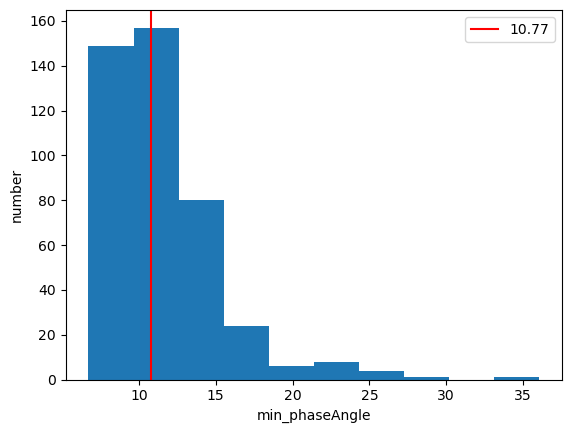

median(max_phaseAngle) = 11.800634384155273


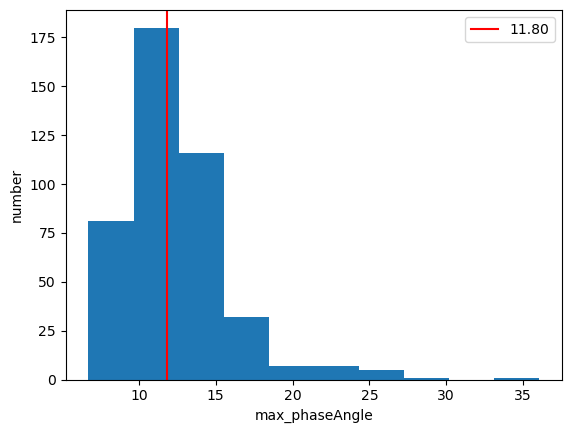

median(range_phaseAngle) = 0.4159836769104004


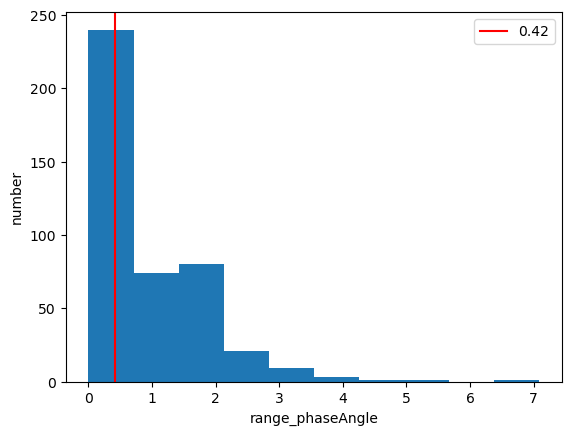

In [23]:
df_plot = df_mag

for x_plot in ["min_phaseAngle","max_phaseAngle","range_phaseAngle"]:
               
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])
    
    ax1.hist(df_plot[x_plot])

    med_x = np.median(df_plot[x_plot])
    print("median({}) = {}".format(x_plot,med_x))
    ax1.axvline(med_x, c= "r", label = "{:.2f}".format(med_x))
        
    ax1.legend()
    ax1.set_xlabel(x_plot)
    ax1.set_ylabel("number")
    
    plt.show()

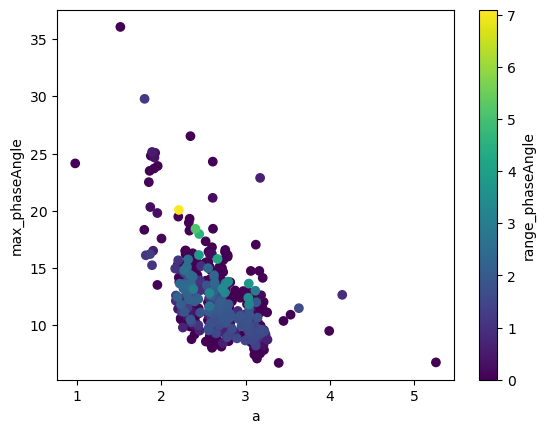

In [24]:
# plot the maximum observed phase angle for each object as a function of semimajor axis
x_plot = "a"
y_plot = "max_phaseAngle"
c_plot = "range_phaseAngle"
df_plot = df_mag.sort_values(c_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot], c = df_plot[c_plot])
cbar1 = plt.colorbar(s1)

# Maximum possible phase angle as a function of semimajor axis (for circular orbit)
# _x = np.linspace(np.amin(df_plot[x_plot]),np.amax(df_plot[x_plot]))
# ax1.plot(_x, np.arcsin(1.0/_x), c = "r")

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
cbar1.set_label(c_plot)

plt.show()


In [25]:
# plot the object with the largest phase curve coverage
ssobjid = df_mag.iloc[np.argmax(df_mag["range_phaseAngle"])]["ssObjectId"]

21163611662530641 2001 SQ248
g 7
i 7
r 6
z 2


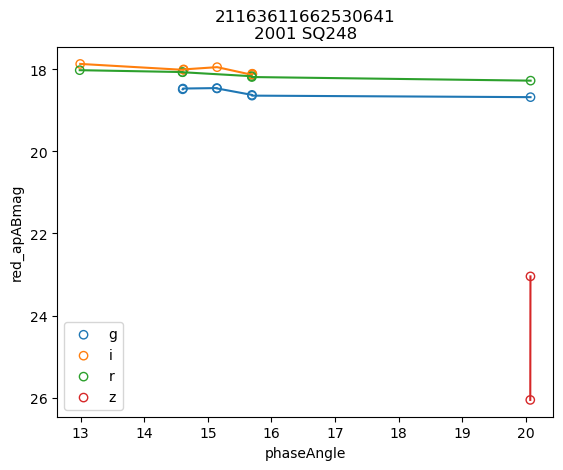

In [26]:
# Plot the phase curve
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
print(ssobjid,mpc_des)

x_plot = "phaseAngle"
y_plot = "red_apABmag"
df_plot = df_obs[df_obs["ssObjectId"] == ssobjid].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))
    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                edgecolor = "C{}".format(i),
                facecolor = "none",
                label = filt)
    ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
             c = "C{}".format(i),)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()

plt.title("{}\n{}".format(ssobjid,mpc_des))

plt.show()


21163611662530641 2001 SQ248
g 7
i 7
r 6
z 2


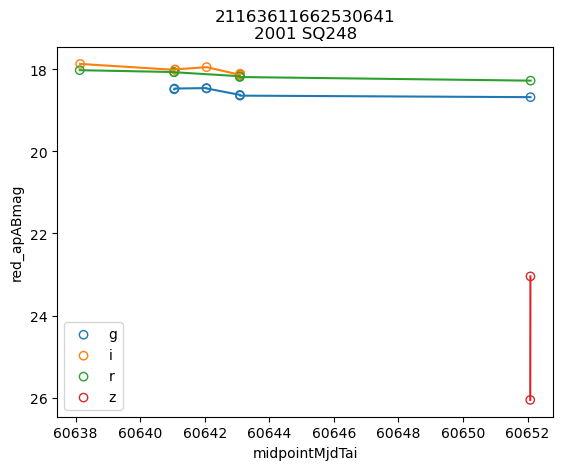

In [27]:
# Look at the lightcurve (note that this is very similar to the phase curve given the small observing baseline)
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
print(ssobjid,mpc_des)

x_plot = "midpointMjdTai"
y_plot = "red_apABmag"
df_plot = df_obs[df_obs["ssObjectId"] == ssobjid].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))
    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                edgecolor = "C{}".format(i),
                facecolor = "none",
                label = filt)
    ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
             c = "C{}".format(i),)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()

plt.title("{}\n{}".format(ssobjid,mpc_des))

plt.show()


# Unusual photometry?
ssObjectId = 21163611662530641 appears to have extremely faint detections in the z band. This seems fishy, let's look at the observations:

In [28]:
# Inspect all observations in full
df = df_obs[df_obs["ssObjectId"] == ssobjid]
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(df)
df

,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,band,bboxSize,centroid_flag,coord_dec,coord_ra,dec,...,x,xErr,y,yErr,apABmag,psfABmag,trailABmag,red_apABmag,red_psfABmag,red_trailABmag
29,90370.601562,534.776001,False,False,r,36,False,7.425406,38.617229,7.425406,...,3388.105749,0.013128,2709.919818,0.016460,19.009932,19.009518,19.025862,18.017624,18.017210,18.033554
30,104010.000000,755.590027,False,False,i,36,False,7.424557,38.615154,7.424557,...,3369.234559,0.015195,2732.934560,0.016192,18.857313,18.854736,18.918356,17.864859,17.862282,17.925901
1120,45.861801,1659.790039,False,False,z,35,False,6.970732,37.399063,6.970732,...,293.110183,NaN,1073.256631,NaN,27.246372,25.356487,NaN,26.058342,24.168457,NaN
1123,735.200989,1656.949951,False,False,z,29,False,6.970732,37.399063,6.970735,...,1006.716354,NaN,1526.804558,NaN,24.233986,21.845695,NaN,23.045853,20.657562,NaN
1124,41178.500000,526.544006,False,False,g,34,False,6.970732,37.399063,6.970727,...,346.401895,0.028918,1078.244360,0.031137,19.863325,19.891842,19.958284,18.675158,18.703674,18.770117
1125,59648.300781,574.835022,False,False,r,36,False,6.970732,37.399063,6.970734,...,364.729542,0.024835,1077.436805,0.021595,19.461006,19.464079,19.548700,18.272781,18.275854,18.360476
2390,74597.000000,519.927979,False,False,r,34,False,7.158129,37.996333,7.158179,...,1486.429344,0.014155,1195.760879,0.014849,19.218199,19.188774,19.290655,18.164494,18.135069,18.236950
2393,73219.101562,524.982971,False,False,r,33,False,7.158129,37.996333,7.158080,...,1046.137297,0.015219,1873.532971,0.014481,19.238440,19.210495,19.325144,18.184706,18.156761,18.271410
2394,49047.300781,405.205994,False,False,g,33,False,7.157921,37.995743,7.157973,...,1508.730062,0.018133,1206.819853,0.018270,19.673464,19.643742,19.726097,18.619694,18.589972,18.672327
2397,48218.300781,410.117004,False,False,g,34,False,7.157921,37.995743,7.157866,...,1068.825092,0.018738,1883.784204,0.018056,19.691971,19.647390,19.707428,18.638170,18.593590,18.653627


The faint detections have a number of nan values, which appear to be caused by an attempted dipole fit (`dipoleFitAttempted == True`)
See also ssObjectId for another example 21163611677341266.

Furthermore some objects (e.g. ssObjectId = 23133931615302707) still have faint measurements, and these have nan values for trailing measurements (`shape_flag == True`).
NB not all observations with `shape_flag == True` appear to be outlying.

In [29]:
# dipoleFitAttempted==True example objects
# ssobjid = 21163611662530641
# ssobjid = 21163611677341266

# shape_flag==True example object
ssobjid = 23133931615302707

In [30]:
# Inspect all observations in full
df = df_obs[df_obs["ssObjectId"] == ssobjid]
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(df)
df

,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,band,bboxSize,centroid_flag,coord_dec,coord_ra,dec,...,x,xErr,y,yErr,apABmag,psfABmag,trailABmag,red_apABmag,red_psfABmag,red_trailABmag
3291,806.197021,476.967010,False,False,r,16,False,6.607850,37.787872,6.607850,...,2321.280151,0.750622,2774.654475,1.319700,24.133900,23.744862,23.644569,19.950911,19.561872,19.461580
3295,1153.229980,477.677002,False,False,r,16,False,6.607778,37.787482,6.607778,...,1880.373661,0.424435,3453.662381,0.343537,23.745213,23.563673,23.568665,19.562202,19.380663,19.385654
3299,728.994019,357.494995,False,False,g,16,False,6.607827,37.787036,6.607827,...,2340.159157,0.366115,2787.561491,0.360613,24.243191,23.845707,23.907507,20.060154,19.662670,19.724470
3303,508.674011,353.748993,False,False,g,14,False,6.607698,37.785982,6.607698,...,1914.789116,1.618830,3475.144034,1.240970,24.633904,24.190920,24.004604,20.450806,20.007822,19.821507
3308,1183.369995,352.641998,False,False,g,20,False,6.607700,37.785600,6.607700,...,1247.320275,0.450046,1456.238825,0.495489,23.717201,23.645460,23.574440,19.534088,19.462345,19.391327
3319,1401.479980,791.984985,False,False,i,13,False,6.607639,37.783409,6.607639,...,1969.741846,0.361703,3499.746788,0.391212,23.533533,23.305363,NaN,19.350296,19.122124,NaN
3422,809.390991,360.923004,False,False,g,17,False,6.602105,37.637562,6.602105,...,2996.080954,1.124740,2939.388179,0.791861,24.129604,23.910316,23.610950,19.937614,19.718327,19.418961
3457,364.713013,348.213013,False,False,g,16,False,6.602083,37.637883,6.602083,...,3664.782233,0.372945,729.407025,0.919929,24.995125,23.935757,23.879416,20.803156,19.743788,19.687447
3525,1353.719971,420.596985,False,False,r,17,False,6.598293,37.488569,6.598293,...,3822.354316,0.480298,469.299805,0.484492,23.571178,23.579327,23.428362,19.369785,19.377934,19.226969
3529,1029.250000,416.479004,False,False,r,15,False,6.598296,37.488252,6.598296,...,3382.024963,0.501633,1146.109490,0.504248,23.868698,23.863941,23.885399,19.667284,19.662527,19.683985


23133931615302707 2024 WX104
g 6
i 7
r 6


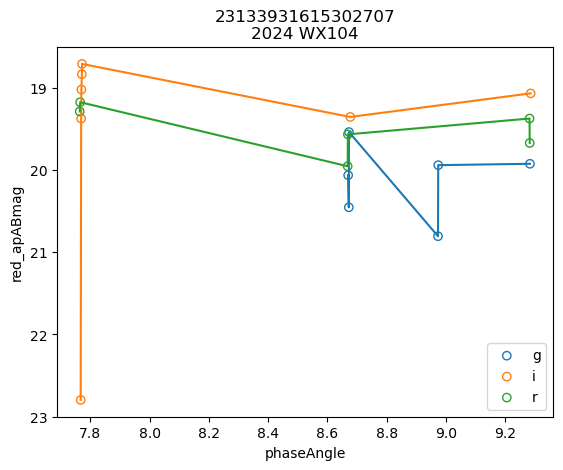

In [31]:
# Plot the phase curve
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
print(ssobjid,mpc_des)

x_plot = "phaseAngle"
y_plot = "red_apABmag"
df_plot = df_obs[df_obs["ssObjectId"] == ssobjid].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))
    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                edgecolor = "C{}".format(i),
                facecolor = "none",
                label = filt)
    ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
             c = "C{}".format(i),)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()

plt.title("{}\n{}".format(ssobjid,mpc_des))

plt.show()


In [32]:
df_obs[~(df_obs["dipoleFitAttempted"])].dropna(subset = ["red_apABmag"])

,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,band,bboxSize,centroid_flag,coord_dec,coord_ra,dec,...,x,xErr,y,yErr,apABmag,psfABmag,trailABmag,red_apABmag,red_psfABmag,red_trailABmag
2,4369.830078,353.485992,False,False,g,30,False,6.293278,37.819684,6.293278,...,22.427637,0.209728,1919.808569,0.221328,22.298840,22.315632,22.283075,18.822573,18.839365,18.806808
3,4400.299805,343.942993,False,False,g,30,False,6.293452,37.820504,6.293452,...,1134.479535,0.144288,3253.946654,0.205547,22.291296,22.377724,22.347549,18.815075,18.901505,18.871330
4,4484.660156,348.970001,False,False,g,27,False,6.293351,37.820085,6.293351,...,690.930377,0.128695,3934.376414,0.170207,22.270678,22.363127,22.367790,18.794434,18.886883,18.891546
5,9565.330078,718.203979,False,False,i,23,False,6.293173,37.819193,6.293173,...,1153.779497,0.094149,3267.275036,0.161130,21.448250,21.450617,21.455692,17.971954,17.974321,17.979397
6,9743.110352,683.086975,False,False,i,28,False,6.293077,37.818787,6.293077,...,710.218686,0.106217,3946.933040,0.154775,21.428257,21.485264,21.439354,17.951939,18.008945,17.963036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,14664.700195,750.836975,False,False,i,28,False,7.892990,37.691233,7.892990,...,1477.648418,0.077689,1323.787451,0.093504,20.984318,20.892101,20.935757,18.598860,18.506643,18.550299
5983,18567.300781,382.354004,False,False,g,29,False,7.852124,37.620779,7.852128,...,814.944672,0.040874,2335.915101,0.042200,20.728130,20.733982,20.772417,18.035534,18.041386,18.079823
5984,22581.800781,386.095001,True,False,g,59,True,7.852093,37.619696,7.852093,...,386.736761,0.036542,3019.762131,0.033804,20.515604,20.489614,NaN,17.822927,17.796938,NaN
5985,24185.199219,402.345001,False,False,g,32,False,7.852046,37.618389,7.852046,...,2211.760655,0.034983,1236.339713,0.031280,20.441128,20.436213,20.475773,17.748354,17.743439,17.782999


# Group by ssObjectId and band
These summary stats allow us to assess changes in brightness in each band for each object.
Significant changes in a single band could indicate a rotational amplitude (or weird measurements).
Changes between mean brightness in different bands for a given object indicate colours.

In [33]:
# We want to exclude unusual photometry from our summary statistics so we define a mask
all_obs_mask = ~((df_obs["dipoleFitAttempted"]) | (df_obs["shape_flag"]))

# drop anything with a flag for dipole or shape
df_obs[~all_obs_mask][["shape_flag","dipoleFitAttempted"]]

,shape_flag,dipoleFitAttempted
0,False,True
1,False,True
10,True,True
21,True,True
23,False,True
...,...,...
5968,False,True
5981,False,True
5982,False,True
5984,True,False


In [34]:
# generate the summary statistics, by object and band, and excluding possible weird photometry
gb_obs_band = df_obs[all_obs_mask].dropna(subset = ["red_apABmag","red_psfABmag","red_trailABmag"]).groupby(["ssObjectId","band"])

df_ptp_band = gb_obs_band[['red_apABmag',"red_psfABmag","red_trailABmag","phaseAngle"]].agg(np.ptp).reset_index()
df_ptp_band = df_ptp_band.rename({'red_apABmag':"range_red_apABmag",
                                  'red_psfABmag':"range_red_psfABmag",
                                  'red_trailABmag':"range_red_trailABmag",
                        "phaseAngle":"range_phaseAngle"}, axis = 1)

df_min_band = gb_obs_band[["red_apABmag","red_psfABmag","red_trailABmag","phaseAngle"]].min().reset_index()
df_min_band = df_min_band.rename({'red_apABmag':"min_red_apABmag",
                                  'red_psfABmag':"min_red_psfABmag",
                                  'red_trailABmag':"min_red_trailABmag",
                        "phaseAngle":"min_phaseAngle"}, axis = 1)

df_max_band = gb_obs_band[["red_apABmag","red_psfABmag","red_trailABmag","phaseAngle"]].min().reset_index()
df_max_band = df_max_band.rename({'red_apABmag':"max_red_apABmag",
                                  'red_psfABmag':"max_red_psfABmag",
                                  'red_trailABmag':"max_red_trailABmag",
                        "phaseAngle":"max_phaseAngle"}, axis = 1)

df_mean_band = gb_obs_band[["red_apABmag","red_psfABmag","red_trailABmag","phaseAngle"]].mean().reset_index()
df_mean_band = df_mean_band.rename({'red_apABmag':"mean_red_apABmag",
                                    'red_psfABmag':"mean_red_psfABmag",
                                    'red_trailABmag':"mean_red_trailABmag",
                        "phaseAngle":"mean_phaseAngle"}, axis = 1)

df_mag_band = df_ptp_band.copy()
df_mag_band = df_mag_band.merge(df_min_band, on = ["ssObjectId","band"])
df_mag_band = df_mag_band.merge(df_max_band, on = ["ssObjectId","band"])
df_mag_band = df_mag_band.merge(df_mean_band, on = ["ssObjectId","band"])
# df_mag_band = df_mag_band.merge(df_obj, on = "ssObjectId")

# Inspect the object with the most observations

In [35]:
df_obj.iloc[np.argmax(df_obj["numObs"])]

discoverySubmissionDate                  NaN
e                                   0.094924
epoch                                60600.0
incl                               26.629507
mpcDesignation                     2003 QT30
mpcH                               17.618999
node                               162.15573
numObs                                   133
peri                               152.13514
q                                   1.709361
ssObjectId                 21163620217073748
t_p                             60398.283691
a                                   1.888638
Name: 67, dtype: object

In [36]:
ssobjid = df_obj.iloc[np.argmax(df_obj["numObs"])]["ssObjectId"] # ssObjectId with the most observations

In [37]:
df = df_obs[(all_obs_mask) & (df_obs["ssObjectId"] == ssobjid)]
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(df)
df

,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,band,bboxSize,centroid_flag,coord_dec,coord_ra,dec,...,x,xErr,y,yErr,apABmag,psfABmag,trailABmag,red_apABmag,red_psfABmag,red_trailABmag
357,9320.150391,301.334015,False,False,g,29,False,-28.540516,53.393877,-28.540516,...,178.511751,0.052679,3007.864587,0.056040,21.476442,21.463692,21.564339,19.707380,19.694630,19.795277
358,9931.669922,317.500000,False,False,g,26,False,-28.540035,53.392936,-28.540035,...,195.536799,0.053285,3029.281716,0.061062,21.407444,21.409245,21.505661,19.638332,19.640133,19.736549
359,10254.299805,307.134003,False,False,g,27,False,-28.539789,53.392465,-28.539789,...,287.195316,0.058604,3448.086646,0.062330,21.372738,21.369282,21.438137,19.603601,19.600145,19.669001
360,24076.300781,702.749023,False,False,i,22,False,-28.544224,53.401151,-28.544223,...,484.514021,0.040524,124.420649,0.041882,20.446026,20.555164,20.696333,18.677347,18.786486,18.927654
361,12913.200195,331.558014,False,False,g,25,False,-28.543906,53.400537,-28.543909,...,2961.895085,0.042450,3957.023161,0.041181,21.122417,21.164568,21.242702,19.353706,19.395857,19.473991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,30509.099609,1214.369995,False,False,z,24,False,-28.174700,52.799954,-28.174808,...,3361.194507,0.055606,2248.109995,0.058531,20.188927,20.097181,20.171366,18.385023,18.293278,18.367462
2244,32735.699219,1236.550049,False,False,z,26,False,-28.174442,52.799590,-28.174414,...,785.744948,0.057434,2738.213842,0.068139,20.112448,20.126352,20.186064,18.308510,18.322414,18.382126
2245,18892.500000,1182.130005,False,False,z,28,False,-28.170666,52.794124,-28.170694,...,513.870426,0.130967,1833.359633,0.126087,20.709278,20.700186,20.816381,18.905014,18.895922,19.012117
2246,7924.350098,328.725006,False,False,g,29,False,-28.170407,52.793753,-28.170376,...,3822.685954,0.074806,1697.599849,0.104264,21.652592,21.746979,21.697378,19.848299,19.942686,19.893085


In [38]:
len(df)

129

In [39]:
df_obs[(~all_obs_mask) & (df_obs["ssObjectId"] == ssobjid)]

,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,band,bboxSize,centroid_flag,coord_dec,coord_ra,dec,...,x,xErr,y,yErr,apABmag,psfABmag,trailABmag,red_apABmag,red_psfABmag,red_trailABmag
2157,24952.000000,1305.369995,False,False,z,28,False,-28.308505,52.996375,-28.308575,...,3318.593253,NaN,368.300804,NaN,20.407238,22.028330,20.337612,18.615446,20.236538,18.545820
2162,23528.900391,1233.239990,False,False,z,29,False,-28.307801,52.995247,-28.307793,...,3576.292575,NaN,1390.360917,NaN,20.470999,21.921726,20.262695,18.679108,20.129835,18.470804
2188,24256.099609,1307.010010,False,False,z,29,False,-28.308748,52.996790,-28.308689,...,2252.643728,NaN,2957.484054,NaN,20.437948,21.668274,20.287369,18.646137,19.876463,18.495558
2248,31019.000000,1196.280029,True,False,z,26,True,-28.175048,52.800635,-28.174983,...,818.000000,NaN,16.000000,NaN,20.170933,20.752859,NaN,18.367052,18.948978,NaN


g 34
i 14
r 28
z 53


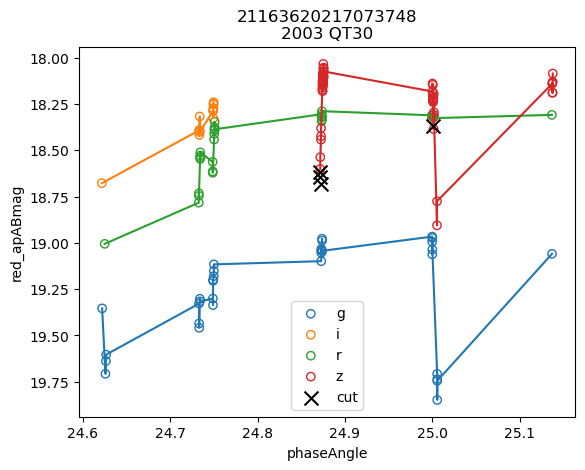

In [40]:
# plot the phase curve and indicate observations that we have excluded
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
x_plot = "phaseAngle"
y_plot = "red_apABmag"
df_plot = df_obs[all_obs_mask & (df_obs["ssObjectId"] == ssobjid)].sort_values(x_plot)
df_plot2 = df_obs[(~all_obs_mask) & (df_obs["ssObjectId"] == ssobjid)].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

            
mlist = ["o","s","*"]
slist = [50,75,100]
for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))
    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                edgecolor = "C{}".format(i),
                facecolor = "none",
                # marker = mlist[i],
                # s = slist[i],
                label = filt)
    ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
             c = "C{}".format(i),)

ax1.scatter(df_plot2[x_plot],df_plot2[y_plot],
            s = 100,
            marker = "x", c = "k", label = "cut", zorder = 5)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()

plt.title("{}\n{}".format(ssobjid,mpc_des))
plt.savefig("{}_{}".format(ssobjid,"_".join(mpc_des.split(" "))))

plt.show()


# What is the relation between the different flux/mag measurements?
DiaSource gives a number of flux measurements, in particular:
- aperture
- psf
- trailed

21163620217073748 2003 QT30


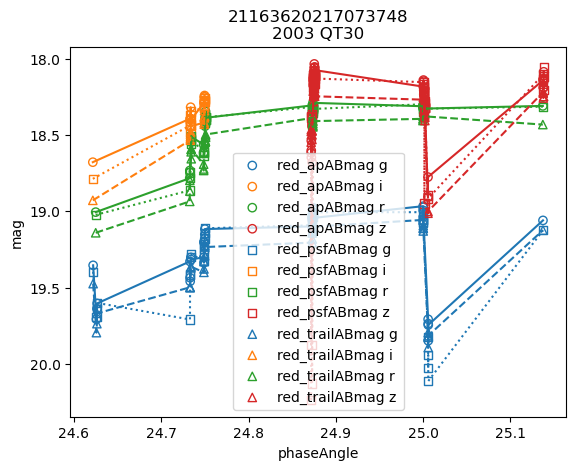

In [41]:
# Plot the phase curve in multiple flux methods for a given object
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
print(ssobjid,mpc_des)

x_plot = "phaseAngle"
df_plot = df_obs[df_obs["ssObjectId"] == ssobjid].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for y_plot,m,ls in zip(["red_apABmag","red_psfABmag","red_trailABmag"],["o","s","^"],["-",":","--"]):
    for i,filt in enumerate(np.unique(df_plot["band"])):
        _df_plot = df_plot[df_plot["band"]==filt]
        ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                    edgecolor = "C{}".format(i),
                    facecolor = "none",
                    marker = m,
                    label = "{} {}".format(y_plot,filt))
        ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
                 ls = ls,
                 c = "C{}".format(i),)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel("mag")
ax1.invert_yaxis()

plt.title("{}\n{}".format(ssobjid,mpc_des))

plt.show()


g 1916


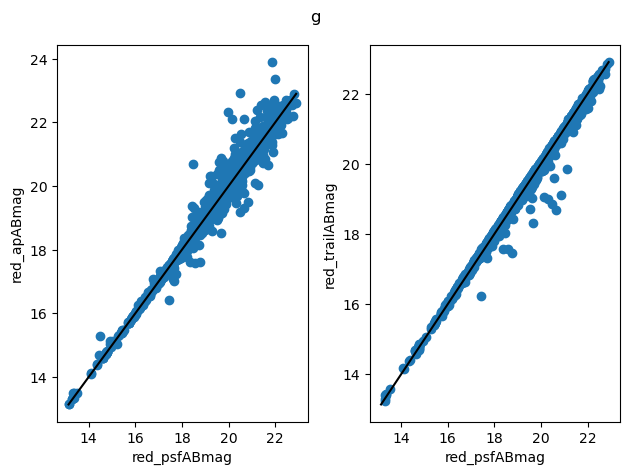

i 2088


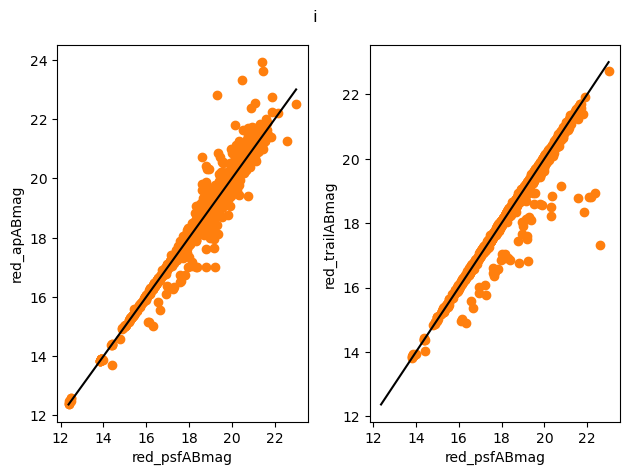

r 1536


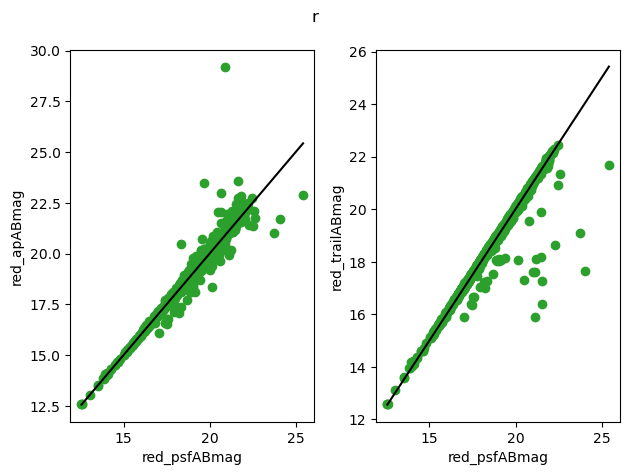

u 15


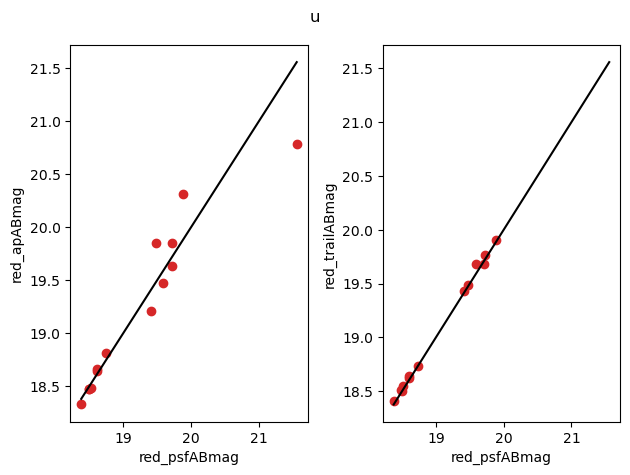

z 433


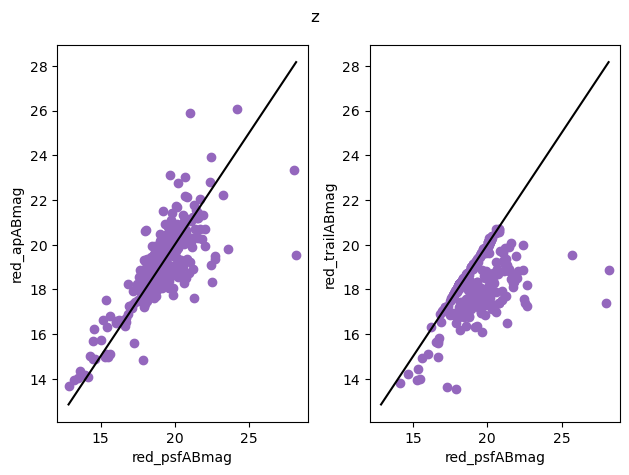

In [42]:
# check the relation between different flux methods
x_plot = "red_psfABmag"
y_plot = "red_apABmag"
y_plot2 = "red_trailABmag"
df_plot = df_obs

for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))

    fig = plt.figure()
    gs = gridspec.GridSpec(1, 2)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])

    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                c = "C{}".format(i),)

    ax1.plot([np.amin(_df_plot[x_plot]),np.amax(_df_plot[x_plot])],
              [np.amin(_df_plot[x_plot]),np.amax(_df_plot[x_plot])],
                                               c = "k")

    ax2.scatter(_df_plot[x_plot],_df_plot[y_plot2],
                c = "C{}".format(i),)

    ax2.plot([np.amin(_df_plot[x_plot]),np.amax(_df_plot[x_plot])],
              [np.amin(_df_plot[x_plot]),np.amax(_df_plot[x_plot])],
                                               c = "k")

    fig.suptitle(filt)
    ax1.set_xlabel(x_plot)
    ax1.set_ylabel(y_plot)
    ax2.set_xlabel(x_plot)
    ax2.set_ylabel(y_plot2)

    plt.tight_layout()
    plt.show()


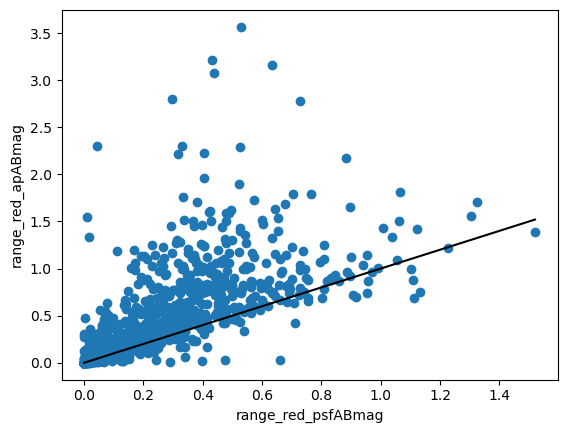

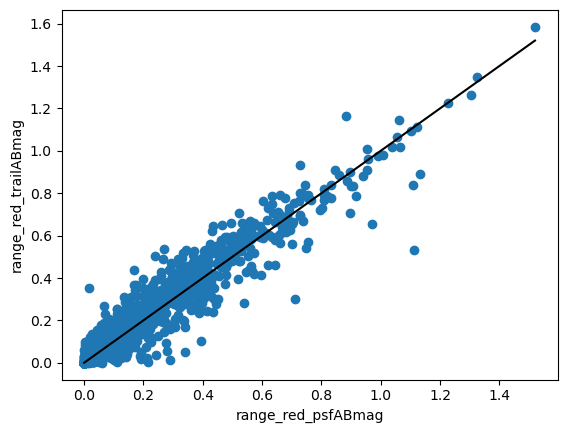

In [43]:
# What method should we use to assess changes in brightness of an object?
# assess the relation between the range statistics of the reduced magnitudes
x_plot = "range_red_psfABmag"
df_plot = df_mag_band

for y_plot in ["range_red_apABmag","range_red_trailABmag"]:
               
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])
    
    ax1.scatter(df_plot[x_plot],df_plot[y_plot])
        

    ax1.plot([np.amin(df_plot[x_plot]),np.amax(df_plot[x_plot])],
              [np.amin(df_plot[x_plot]),np.amax(df_plot[x_plot])],
                                               c = "k")
    
    ax1.set_xlabel(x_plot)
    ax1.set_ylabel(y_plot)
    
    plt.show()

Aperture magnitudes appear to overestimate the range statistic, use psf or trailed instead

In [44]:
df_mag_band.sort_values("range_red_psfABmag")

,ssObjectId,band,range_red_apABmag,range_red_psfABmag,range_red_trailABmag,range_phaseAngle,min_red_apABmag,min_red_psfABmag,min_red_trailABmag,min_phaseAngle,max_red_apABmag,max_red_psfABmag,max_red_trailABmag,max_phaseAngle,mean_red_apABmag,mean_red_psfABmag,mean_red_trailABmag,mean_phaseAngle
0,20890932542191434,r,0.000000,0.000000,0.000000,0.000000,16.914629,16.891289,16.963734,13.537582,16.914629,16.891289,16.963734,13.537582,16.914629,16.891289,16.963734,13.537582
3,20890950007009348,g,0.000000,0.000000,0.000000,0.000000,13.515736,13.515648,13.569553,12.401078,13.515736,13.515648,13.569553,12.401078,13.515736,13.515648,13.569553,12.401078
1106,23133931615303734,i,0.000000,0.000000,0.000000,0.000000,21.106291,21.105425,21.086863,13.051321,21.106291,21.105425,21.086863,13.051321,21.106291,21.105425,21.086863,13.051321
4,20890950007009348,r,0.000000,0.000000,0.000000,0.000000,13.021914,13.024063,13.123085,12.402100,13.021914,13.024063,13.123085,12.402100,13.021914,13.024063,13.123085,12.402100
74,21163611526346049,i,0.000000,0.000000,0.000000,0.000000,17.483479,17.471437,17.547926,8.789922,17.483479,17.471437,17.547926,8.789922,17.483479,17.471437,17.547926,8.789922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,21164724124727367,i,0.753725,1.133451,0.890890,0.981040,20.156754,20.119890,20.175570,13.805681,20.156754,20.119890,20.175570,13.805681,20.373936,20.469776,20.449219,14.389399
445,21164710955528273,i,1.217495,1.226242,1.227415,1.496894,18.070066,18.093655,18.075657,9.240316,18.070066,18.093655,18.075657,9.240316,18.473112,18.498974,18.453951,10.312421
1025,23133931615302969,i,1.556950,1.303993,1.263535,0.926290,19.448683,19.628761,19.602154,11.735900,19.448683,19.628761,19.602154,11.735900,20.350758,20.367460,20.318186,12.195651
1024,23133931615302969,g,1.709867,1.323189,1.349358,0.933676,20.176586,20.214581,20.145849,11.726223,20.176586,20.214581,20.145849,11.726223,21.084309,21.002569,20.922474,12.145342


In [45]:
ssobjid = df_mag_band.iloc[np.argmax(df_mag_band["range_red_psfABmag"])]["ssObjectId"]

g 4
i 7
r 4


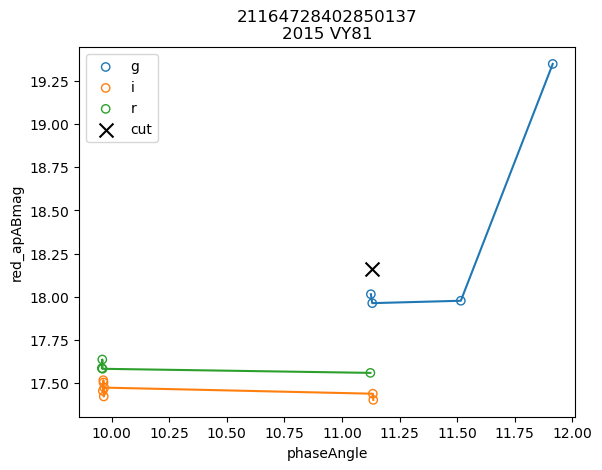

In [46]:
# plot the phase curve and indicate observations that we have excluded
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
x_plot = "phaseAngle"
y_plot = "red_apABmag"
df_plot = df_obs[all_obs_mask & (df_obs["ssObjectId"] == ssobjid)].sort_values(x_plot)
df_plot2 = df_obs[(~all_obs_mask) & (df_obs["ssObjectId"] == ssobjid)].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

            
mlist = ["o","s","*"]
slist = [50,75,100]
for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))
    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                edgecolor = "C{}".format(i),
                facecolor = "none",
                # marker = mlist[i],
                # s = slist[i],
                label = filt)
    ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
             c = "C{}".format(i),)

ax1.scatter(df_plot2[x_plot],df_plot2[y_plot],
            s = 100,
            marker = "x", c = "k", label = "cut", zorder = 5)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.title("{}\n{}".format(ssobjid,mpc_des))

plt.show()
